numpy ver.: 1.19.2
pandas ver.: 1.0.3
tensorflow ver.: 1.14.0
keras ver.: 2.3.1


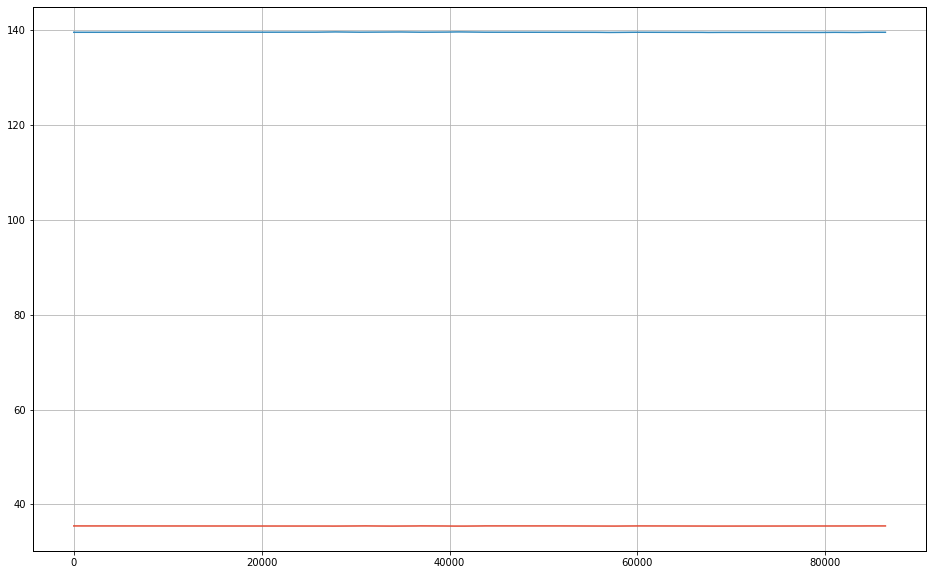

         lat         lng
0  35.456029  139.611249
1  35.456029  139.611249
2  35.456029  139.611249
3  35.456029  139.611249
4  35.456029  139.611249


In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import keras.backend.tensorflow_backend as ktf

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + numpy.__version__)
print('pandas ver.: ' + pandas.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)
#データ読み込み
dataframe = pandas.read_csv('/home/hailin/Documents/kmu/data/1589.csv', usecols=[1,2], engine='python', skipfooter=1)
plt.plot(dataframe)
plt.show()
print(dataframe.head())

In [4]:
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

57887 28512


In [5]:
print(dataset[0:3])

[[0.7772827 0.3031006]
 [0.7772827 0.3031006]
 [0.7772827 0.3031006]]


In [9]:
# convert an array of values into a dataset matrix
# if you give look_back 3, a part of the array will be like this: Jan, Feb, Mar
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
        dataX.append(xset)
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i+look_back, j]
            xset.append(a)
        dataY.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX.shape)
print(testX[1,0])
print(testY.shape)

trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))
testY = testY.reshape((testY.shape[0], testY.shape[1], 1))

# reshape input to be [samples, time steps(number of variables), features] *convert time series into column
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[2], trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))
trainY = numpy.reshape(trainY, (trainY.shape[0], trainY.shape[2], trainY.shape[1]))
testY = numpy.reshape(testY, (testY.shape[0], testY.shape[2], testY.shape[1]))

print(testX.shape)
print(testY.shape)

print(trainX.shape)
print(trainY.shape)


(28481, 2, 30)
[0.18536377 0.18566895 0.18591309 0.18603516 0.18609619 0.18603516
 0.18603516 0.18603516 0.18603516 0.18603516 0.18603516 0.18603516
 0.18603516 0.18603516 0.18603516 0.18603516 0.18603516 0.18609619
 0.18621826 0.1862793  0.1864624  0.18682861 0.18719482 0.18756104
 0.18804932 0.18859863 0.18933105 0.19006348 0.19091797 0.19189453]
(28481, 2)
(28481, 30, 2)
(28481, 1, 2)
(57856, 30, 2)
(57856, 1, 2)


In [62]:
trainX = trainX.reshape((trainX.shape[0], 3, 10, 2, 1))
testX = testX.reshape((testX.shape[0], 3, 10, 2, 1))

print(trainX.shape)
print(testX.shape)

trainY = trainY.reshape((trainY.shape[0], 1, trainY.shape[1], 2, 1))
testY = testY.reshape((testY.shape[0], 1, testY.shape[1], 2, 1))

print(trainY.shape)
print(testY.shape)

(57856, 3, 10, 2, 1)
(28481, 3, 10, 2, 1)
(57856, 1, 1, 2, 1)
(28481, 1, 1, 2, 1)


In [63]:
# create ConvLSTM
n_timesteps = trainX.shape[1]
output_timesteps = 1
model = Sequential()
model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (n_timesteps, trainX.shape[2], trainX.shape[3], 1)))
model.add(ConvLSTM2D(name ='conv_lstm_1',
                     filters = 64, kernel_size = (10, 1),                       
                     padding = 'same', 
                     return_sequences = True))
    
model.add(Dropout(0.21, name = 'dropout_1'))
model.add(BatchNormalization(name = 'batch_norm_1'))

model.add(ConvLSTM2D(name ='conv_lstm_2',
                     filters = 64, kernel_size = (5, 1), 
                     padding='same',
                     return_sequences = False))
    
model.add(Dropout(0.20, name = 'dropout_2'))
model.add(BatchNormalization(name = 'batch_norm_2'))
    
model.add(Flatten())
model.add(RepeatVector(output_timesteps))
model.add(Reshape((output_timesteps, 1, 2, 640)))

model.add(ConvLSTM2D(name ='conv_lstm_3',
                     filters = 64, kernel_size = (10, 1), 
                     padding='same',
                     return_sequences = True))
    
model.add(Dropout(0.1, name = 'dropout_3'))
model.add(BatchNormalization(name = 'batch_norm_3'))
    
model.add(ConvLSTM2D(name ='conv_lstm_4',
                     filters = 64, kernel_size = (5, 1), 
                     padding='same',
                     return_sequences = True))
    
model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
#model.add(Dense(units=1, name = 'dense_2'))

#optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#model.compile(loss = "mse", optimizer = optimizer)
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])
model.fit(trainX, trainY, epochs=120, batch_size=16)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 3, 10, 2, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 3, 10, 2, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 10, 2, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 3, 10, 2, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 10, 2, 64)         164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 2, 64)         0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 10, 2, 64)       

KeyboardInterrupt: 

In [20]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

ValueError: Error when checking input: expected batch_norm_0_input to have 6 dimensions, but got array with shape (57856, 3, 10, 2, 1)

In [57]:
print(trainPredict.shape)
print(testPredict.shape)
print(trainPredict[0:3])
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(57856, 2)
(28481, 2)
[[0.7775779 0.301804 ]
 [0.7775779 0.301804 ]
 [0.7775779 0.301804 ]]
(57856, 30, 2)
(57856, 1, 2)
(28481, 30, 2)
(28481, 1, 2)


In [58]:
trainPredict = numpy.squeeze(trainPredict)
trainY = numpy.squeeze(trainY)
print(trainPredict.shape)
print(trainPredict[0:3])
testPredict = numpy.squeeze(testPredict)
testY = numpy.squeeze(testY)
print(testPredict.shape)
print(testPredict[0:3])

(57856, 2)
[[0.7775779 0.301804 ]
 [0.7775779 0.301804 ]
 [0.7775779 0.301804 ]]
(28481, 2)
[[0.19659302 0.08116185]
 [0.19787708 0.08165801]
 [0.19891748 0.08202649]]


In [59]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [63]:
print(trainPredict[0])
print(trainY[0])
print()
print(testPredict[0])
print(testY[0])

[ 35.45604 139.61111]
[ 35.456028 139.61125 ]

[ 35.43205 139.58624]
[ 35.431854 139.58624 ]


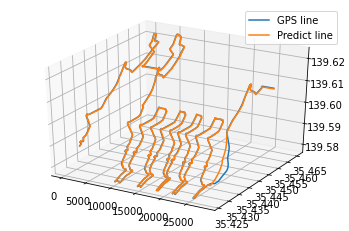

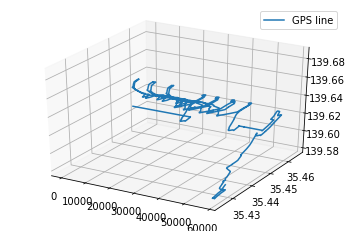

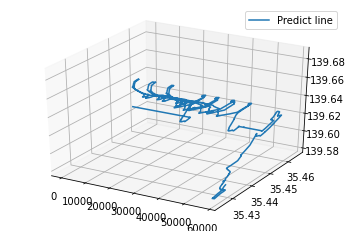

In [76]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

 
mpl.rcParams['legend.fontsize'] = 10
 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(range(len(testY)), testY[:,0], testY[:,1], label='GPS line')
ax.plot(range(len(testPredict)), testPredict[:,0], testPredict[:,1], label='Predict line')
ax.legend()
 
plt.show()


mpl.rcParams['legend.fontsize'] = 10
 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(range(len(trainY)), trainY[:,0], trainY[:,1], label='GPS line')
ax.legend()
plt.show()

mpl.rcParams['legend.fontsize'] = 10
 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(range(len(trainPredict)), trainPredict[:,0], trainPredict[:,1], label='Predict line')
ax.legend()
plt.show()

In [34]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
pad_col = numpy.zeros(dataset.shape[1]-1)

# invert predictions
def pad_array(val):
    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])
    
trainPredict = scaler.inverse_transform(pad_array(trainPredict))
trainY = scaler.inverse_transform(pad_array(trainY))
testPredict = scaler.inverse_transform(pad_array(testPredict))
testY = scaler.inverse_transform(pad_array(testY))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: could not broadcast input array from shape (2) into shape (1)

[ 806.99999854  796.00000856  762.99998096 ... 1033.99998039 1010.99999087
  990.00002051]
[ 794.89061933  789.00033097  760.95777065 ... 1068.0637154   999.78450149
  969.99527085]


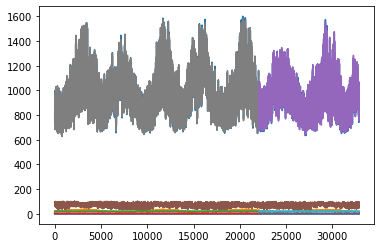

In [17]:
print(testY[:,0])
print(testPredict[:,0])
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

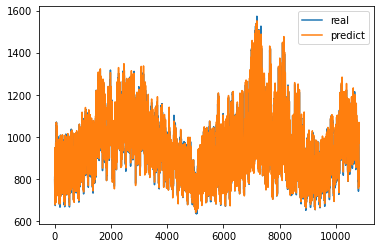

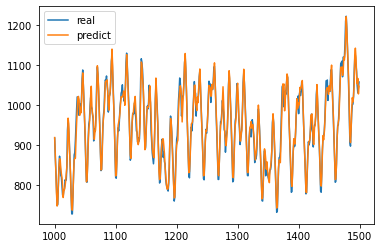

In [18]:
plt.plot(range(len(testY)), testY[:,0], label='real')
plt.plot(range(len(testPredict)), testPredict[:,0], label='predict')
plt.legend() 
plt.show()

plt.plot(range(1000,1500), testY[1000:1500,0], label='real')
plt.plot(range(1000,1500), testPredict[1000:1500,0], label='predict')
plt.legend() 
plt.show()

In [19]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    return np.mean(np.abs((y_true - y_pred)/y_true))

t = mean_absolute_percentage_error(testY[:,0], testPredict[:,0])
print(t)

0.011918163511062025


In [77]:
model.save('/home/hailin/Documents/kmu/data/ltsm.h5')

In [79]:
numpy.savetxt("/home/hailin/Documents/kmu/data/lstm-predicted.csv", testPredict, delimiter=",")
numpy.savetxt("/home/hailin/Documents/kmu/data/lstm-real.csv", testY, delimiter=",")  